# Trasfer learning model

In [1]:
# !pip install seaborn

In [2]:
import numpy as np
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import classification_report

## Dataset

In [3]:
dataset_path = os.path.join('../../Brain Tumor Data Set')
dataset = tf.keras.utils.image_dataset_from_directory(dataset_path)

dataset

Found 4600 files belonging to 2 classes.


<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [4]:
class_names = np.array(dataset.class_names)
print(class_names)

['Brain Tumor' 'Healthy']


### Train - test split

In [5]:
ds_train = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='training',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 3680 files for training.


In [6]:
ds_val = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset='validation',
    seed=404,
    batch_size=64
)

Found 4600 files belonging to 2 classes.
Using 920 files for validation.


In [7]:
for image_batch, labels_batch in ds_train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 256, 256, 3)
(64,)


## Mobilenet_v2 - model without augmentation, with dense & dropout layer

In [8]:
input_shape = (224, 224, 3)

In [9]:
resizer = lambda x, y: (tf.image.resize(x, input_shape[:2]), y)

ds_train_reshaped = ds_train.map(resizer)
ds_val_reshaped = ds_val.map(resizer)

In [10]:
for image_batch, labels_batch in ds_train_reshaped:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [11]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
base_model.trainable = False

x = base_model(input, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(320)(x)
x = keras.layers.Dropout(0.25, seed=404)(x)
x = keras.layers.Dense(64)(x)
x = keras.layers.Dropout(0.25, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_1 = keras.Model(input, output)

model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 320)               409920    
_________________________________________________________________
dropout (Dropout)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                20544     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0     

In [12]:
model_1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [13]:
epochs = 60
patience = 5

In [14]:
history_1 = model_1.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/60
58/58 [==============================] - 73s 1s/step - loss: 0.5600 - binary_accuracy: 0.7992 - val_loss: 0.2840 - val_binary_accuracy: 0.8761
Epoch 2/60
58/58 [==============================] - 90s 2s/step - loss: 0.3410 - binary_accuracy: 0.8625 - val_loss: 0.2409 - val_binary_accuracy: 0.9076
Epoch 3/60
58/58 [==============================] - 111s 2s/step - loss: 0.2710 - binary_accuracy: 0.8943 - val_loss: 0.2121 - val_binary_accuracy: 0.9141
Epoch 4/60
58/58 [==============================] - 112s 2s/step - loss: 0.2433 - binary_accuracy: 0.9041 - val_loss: 0.2330 - val_binary_accuracy: 0.8978
Epoch 5/60
58/58 [==============================] - 111s 2s/step - loss: 0.2180 - binary_accuracy: 0.9174 - val_loss: 0.1918 - val_binary_accuracy: 0.9283
Epoch 6/60
58/58 [==============================] - 112s 2s/step - loss: 0.2594 - binary_accuracy: 0.9043 - val_loss: 0.4548 - val_binary_accuracy: 0.8304
Epoch 7/60
58/58 [==============================] - 111s 2s/step - loss:

In [15]:
history_1.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

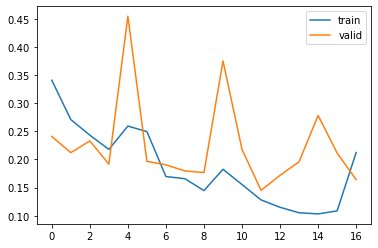

In [16]:
plt.plot(history_1.history['loss'][1:])
plt.plot(history_1.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

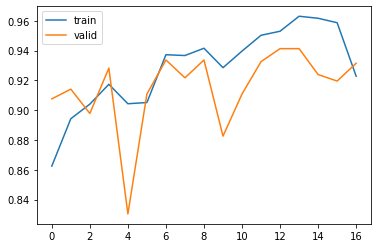

In [17]:
plt.plot(history_1.history['binary_accuracy'][1:])
plt.plot(history_1.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [18]:
x_val_1, y_val_1 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_1 = model_1.predict(x_val_1)
sum((y_pred_1[:, 0] > 0) == y_val_1) / len(y_val_1)

0.953125

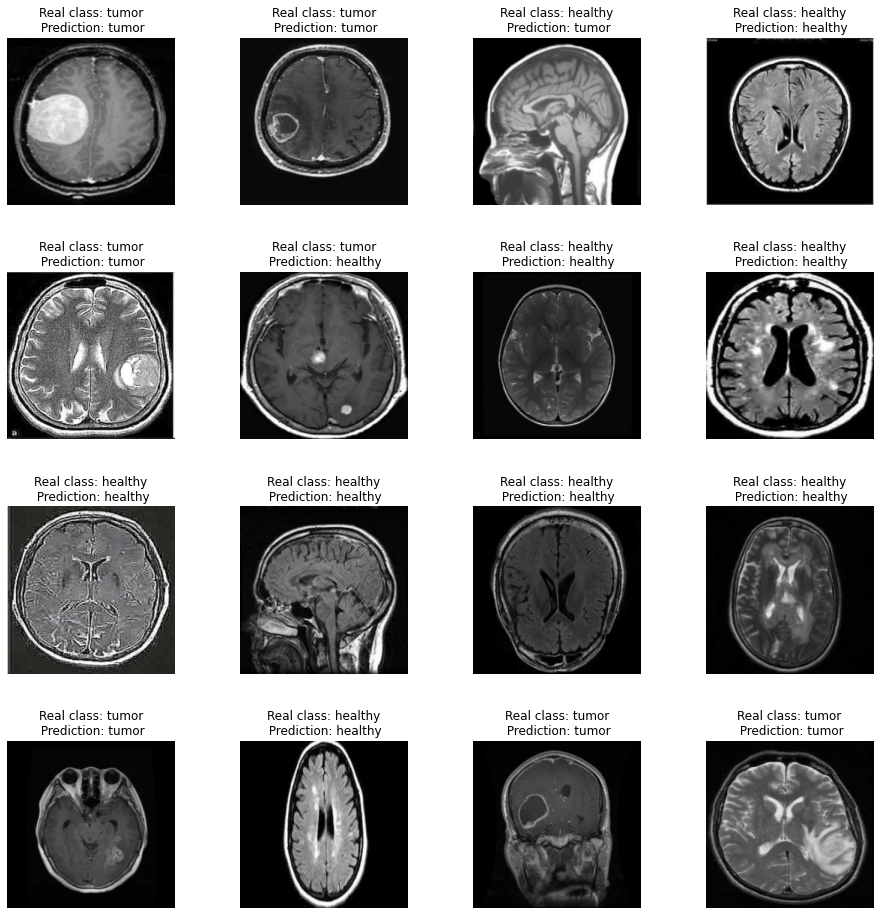

In [19]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_1[i].astype('int32'))
    
    real_y = 'healthy' if y_val_1[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_1[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [20]:
y_pred_1_binary = [1 if y > 0 else 0 for y in y_pred_1]

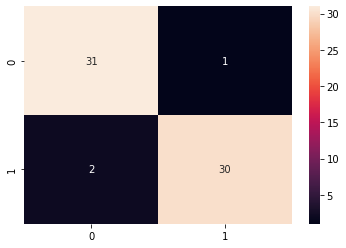

In [21]:
cf = tf.math.confusion_matrix(y_val_1, y_pred_1_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [22]:
print(classification_report(y_val_1, y_pred_1_binary))

              precision    recall  f1-score   support

           0       0.94      0.97      0.95        32
           1       0.97      0.94      0.95        32

    accuracy                           0.95        64
   macro avg       0.95      0.95      0.95        64
weighted avg       0.95      0.95      0.95        64



## Inception_v3 - model without augmentation, with dense & dropout layer

In [23]:
input_shape = (256, 256, 3)

In [24]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    pooling='avg'
)
base_model.trainable = False

x = base_model(input, training=False)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.25, seed=404)(x)
x = keras.layers.Dense(64)(x)
x = keras.layers.Dropout(0.25, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_2 = keras.Model(input, output)

model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65  

In [25]:
model_2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [26]:
epochs = 60
patience = 5

In [27]:
history_2 = model_2.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/60
58/58 [==============================] - 277s 5s/step - loss: 13.8659 - binary_accuracy: 0.5986 - val_loss: 4.0260 - val_binary_accuracy: 0.5652
Epoch 2/60
58/58 [==============================] - 320s 6s/step - loss: 4.6489 - binary_accuracy: 0.6582 - val_loss: 1.5437 - val_binary_accuracy: 0.7533
Epoch 3/60
58/58 [==============================] - 319s 6s/step - loss: 3.7340 - binary_accuracy: 0.6804 - val_loss: 1.2105 - val_binary_accuracy: 0.7913
Epoch 4/60
58/58 [==============================] - 322s 6s/step - loss: 3.0775 - binary_accuracy: 0.7198 - val_loss: 0.9618 - val_binary_accuracy: 0.8239
Epoch 5/60
58/58 [==============================] - 316s 5s/step - loss: 2.6675 - binary_accuracy: 0.7484 - val_loss: 0.8825 - val_binary_accuracy: 0.8511
Epoch 6/60
58/58 [==============================] - 318s 5s/step - loss: 2.7520 - binary_accuracy: 0.7326 - val_loss: 0.8350 - val_binary_accuracy: 0.8685
Epoch 7/60
58/58 [==============================] - 316s 5s/step - lo

In [28]:
history_2.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

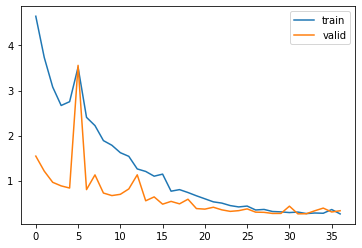

In [29]:
plt.plot(history_2.history['loss'][1:])
plt.plot(history_2.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

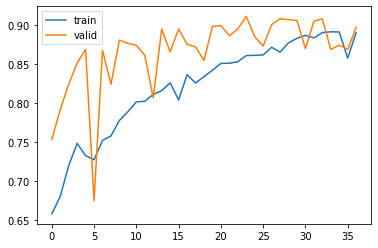

In [30]:
plt.plot(history_2.history['binary_accuracy'][1:])
plt.plot(history_2.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [31]:
x_val_2, y_val_2 = list(tfds.as_numpy(ds_val))[0]
y_pred_2 = model_2.predict(x_val_2)
sum((y_pred_2[:, 0] > 0) == y_val_2) / len(y_val_2)

0.921875

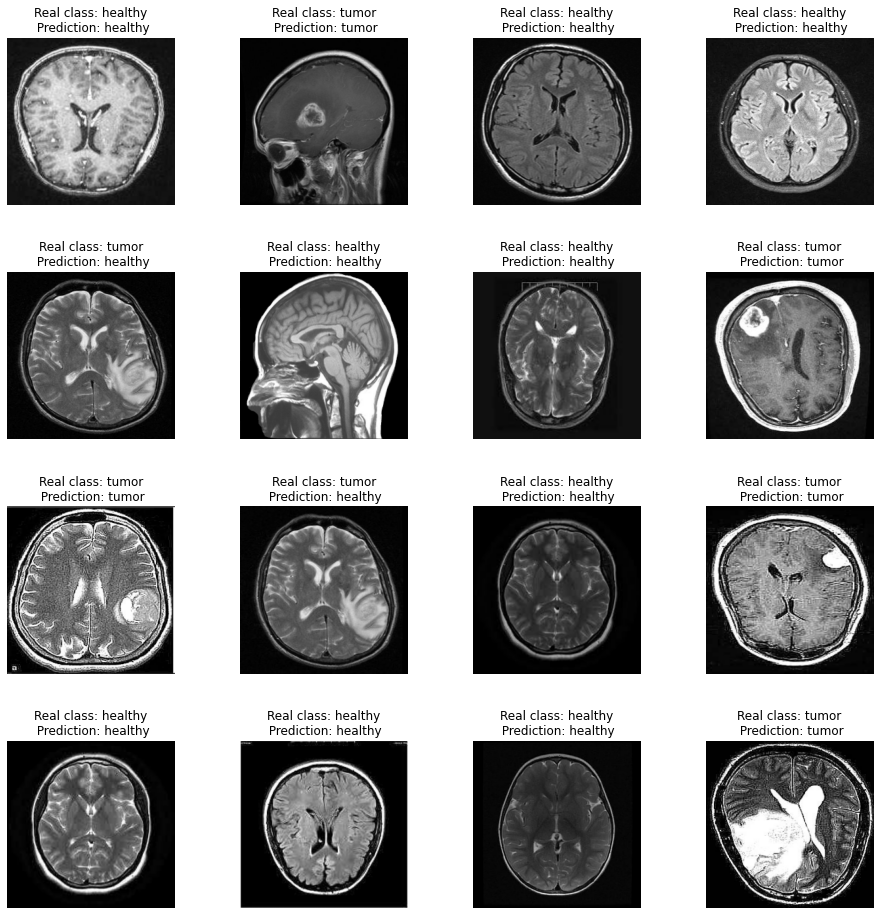

In [32]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_2[i].astype('int32'))
    
    real_y = 'healthy' if y_val_2[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_2[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [33]:
y_pred_2_binary = [1 if y > 0 else 0 for y in y_pred_2]

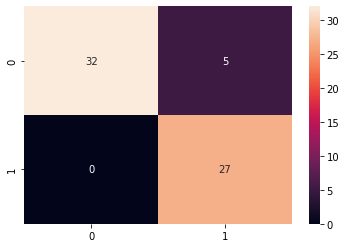

In [34]:
cf = tf.math.confusion_matrix(y_val_2, y_pred_2_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [35]:
print(classification_report(y_val_2, y_pred_2_binary))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93        37
           1       0.84      1.00      0.92        27

    accuracy                           0.92        64
   macro avg       0.92      0.93      0.92        64
weighted avg       0.93      0.92      0.92        64



## Mobilenet_v2 - dropout increase

In [36]:
input_shape = (224, 224, 3)

In [37]:
resizer = lambda x, y: (tf.image.resize(x, input_shape[:2]), y)

ds_train_reshaped = ds_train.map(resizer)
ds_val_reshaped = ds_val.map(resizer)

In [38]:
for image_batch, labels_batch in ds_train_reshaped:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(64, 224, 224, 3)
(64,)


In [39]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = keras.applications.mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False
)
base_model.trainable = False

x = base_model(input, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(320)(x)
x = keras.layers.Dropout(0.4, seed=404)(x)
x = keras.layers.Dense(64)(x)
x = keras.layers.Dropout(0.4, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_3 = keras.Model(input, output)

model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 320)               409920    
_________________________________________________________________
dropout_4 (Dropout)          (None, 320)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                20544     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0   

In [40]:
model_3.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [41]:
epochs = 60
patience = 5

In [42]:
history_3 = model_3.fit(
    ds_train_reshaped,
    epochs=epochs,
    validation_data=ds_val_reshaped,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/60
58/58 [==============================] - 122s 2s/step - loss: 0.6530 - binary_accuracy: 0.7837 - val_loss: 0.3552 - val_binary_accuracy: 0.8554
Epoch 2/60
58/58 [==============================] - 116s 2s/step - loss: 0.3838 - binary_accuracy: 0.8584 - val_loss: 0.2988 - val_binary_accuracy: 0.8837
Epoch 3/60
58/58 [==============================] - 121s 2s/step - loss: 0.3338 - binary_accuracy: 0.8750 - val_loss: 0.2564 - val_binary_accuracy: 0.8891
Epoch 4/60
58/58 [==============================] - 117s 2s/step - loss: 0.3219 - binary_accuracy: 0.8845 - val_loss: 0.3543 - val_binary_accuracy: 0.8880
Epoch 5/60
58/58 [==============================] - 121s 2s/step - loss: 0.3368 - binary_accuracy: 0.8793 - val_loss: 0.2363 - val_binary_accuracy: 0.9098
Epoch 6/60
58/58 [==============================] - 117s 2s/step - loss: 0.2555 - binary_accuracy: 0.9057 - val_loss: 0.2312 - val_binary_accuracy: 0.9185
Epoch 7/60
58/58 [==============================] - 119s 2s/step - los

In [43]:
history_3.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

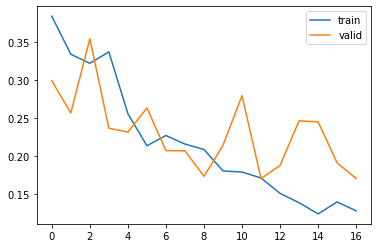

In [44]:
plt.plot(history_3.history['loss'][1:])
plt.plot(history_3.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

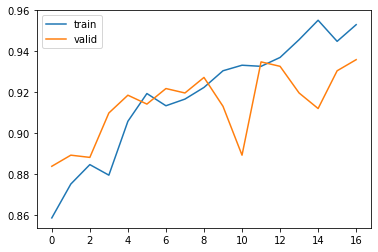

In [45]:
plt.plot(history_3.history['binary_accuracy'][1:])
plt.plot(history_3.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [46]:
x_val_3, y_val_3 = list(tfds.as_numpy(ds_val_reshaped))[0]
y_pred_3 = model_3.predict(x_val_3)
sum((y_pred_3[:, 0] > 0) == y_val_3) / len(y_val_3)

0.96875

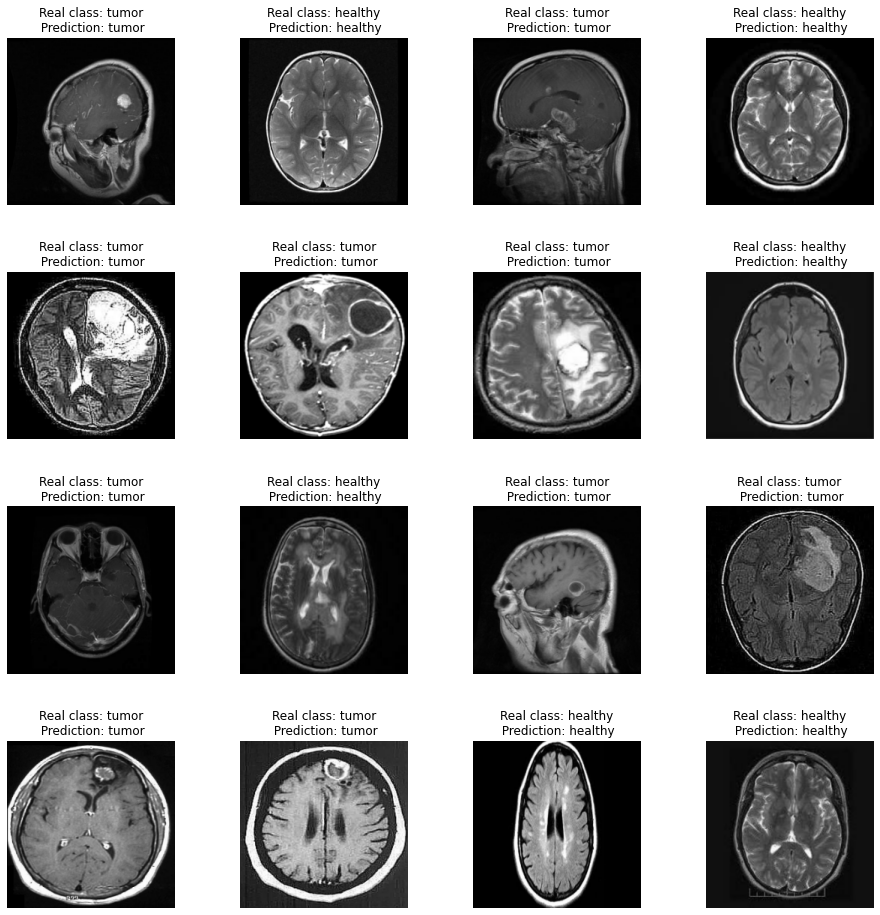

In [47]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_3[i].astype('int32'))
    
    real_y = 'healthy' if y_val_3[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_3[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [48]:
y_pred_3_binary = [1 if y > 0 else 0 for y in y_pred_3]

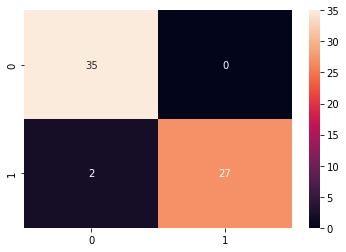

In [49]:
cf = tf.math.confusion_matrix(y_val_3, y_pred_3_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [50]:
print(classification_report(y_val_3, y_pred_3_binary))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        35
           1       1.00      0.93      0.96        29

    accuracy                           0.97        64
   macro avg       0.97      0.97      0.97        64
weighted avg       0.97      0.97      0.97        64



## Inception_v3 - dropout increase

In [51]:
input_shape = (256, 256, 3)

In [52]:
input = keras.layers.Input(input_shape, dtype=tf.float32)

base_model = keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    input_shape=input_shape,
    include_top=False,
    pooling='avg'
)
base_model.trainable = False

x = base_model(input, training=False)
x = keras.layers.Dense(256)(x)
x = keras.layers.Dropout(0.4, seed=404)(x)
x = keras.layers.Dense(64)(x)
x = keras.layers.Dropout(0.4, seed=404)(x)
output = keras.layers.Dense(1)(x)

model_4 = keras.Model(input, output)

model_4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense_9 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65  

In [53]:
model_4.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

In [54]:
epochs = 60
patience = 5

In [55]:
history_4 = model_4.fit(
    ds_train,
    epochs=epochs,
    validation_data=ds_val,
    callbacks=[keras.callbacks.EarlyStopping(patience=patience)]
)

Epoch 1/60
58/58 [==============================] - 327s 6s/step - loss: 16.2145 - binary_accuracy: 0.5967 - val_loss: 2.4843 - val_binary_accuracy: 0.7663
Epoch 2/60
58/58 [==============================] - 322s 6s/step - loss: 8.4033 - binary_accuracy: 0.6546 - val_loss: 2.9711 - val_binary_accuracy: 0.7717
Epoch 3/60
58/58 [==============================] - 320s 6s/step - loss: 6.3186 - binary_accuracy: 0.6967 - val_loss: 4.4855 - val_binary_accuracy: 0.7217
Epoch 4/60
58/58 [==============================] - 320s 6s/step - loss: 6.0575 - binary_accuracy: 0.7095 - val_loss: 1.6559 - val_binary_accuracy: 0.8413
Epoch 5/60
58/58 [==============================] - 320s 6s/step - loss: 5.1685 - binary_accuracy: 0.7201 - val_loss: 1.7300 - val_binary_accuracy: 0.8489
Epoch 6/60
58/58 [==============================] - 323s 6s/step - loss: 4.4865 - binary_accuracy: 0.7505 - val_loss: 2.6487 - val_binary_accuracy: 0.7978
Epoch 7/60
58/58 [==============================] - 325s 6s/step - lo

In [56]:
history_4.history.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

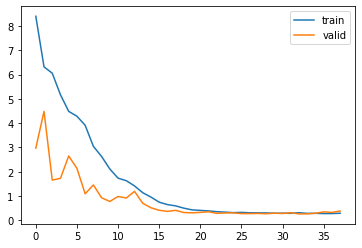

In [57]:
plt.plot(history_4.history['loss'][1:])
plt.plot(history_4.history['val_loss'][1:])
plt.legend(['train', 'valid'])
plt.show();

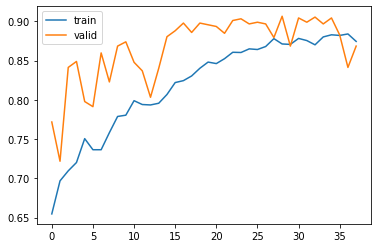

In [58]:
plt.plot(history_4.history['binary_accuracy'][1:])
plt.plot(history_4.history['val_binary_accuracy'][1:])
plt.legend(['train', 'valid'])
plt.show();

### Classification accuracy

In [59]:
x_val_4, y_val_4 = list(tfds.as_numpy(ds_val))[0]
y_pred_4 = model_4.predict(x_val_4)
sum((y_pred_4[:, 0] > 0) == y_val_4) / len(y_val_4)

0.8125

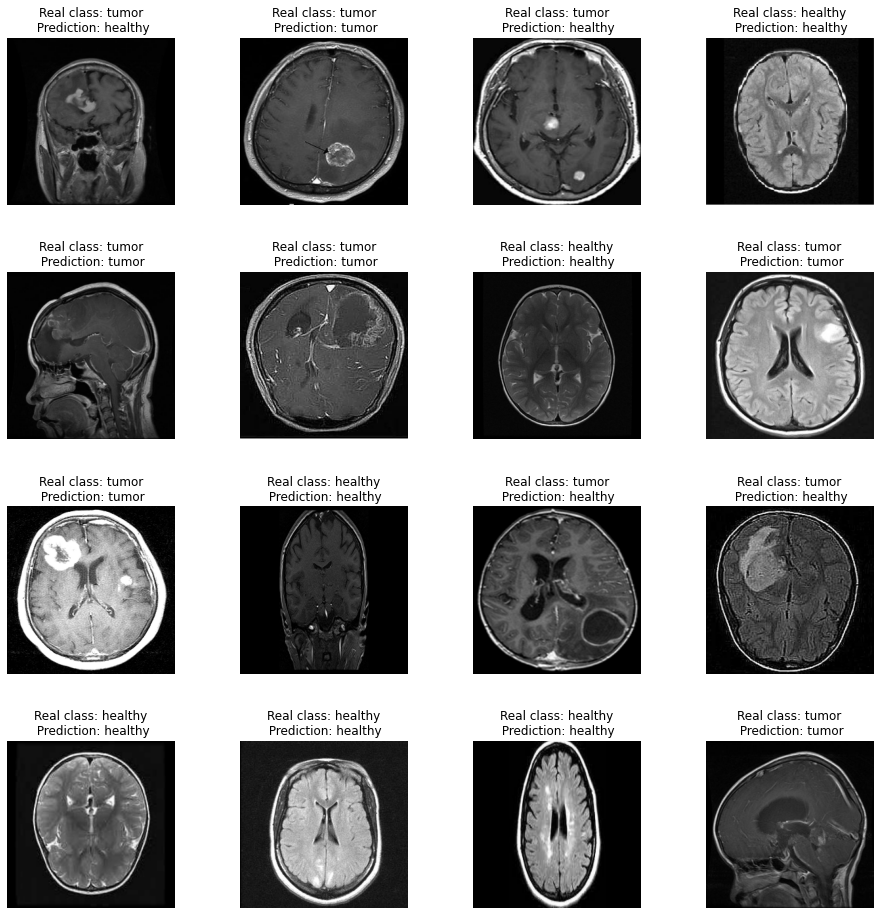

In [60]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=.2)

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(x_val_4[i].astype('int32'))
    
    real_y = 'healthy' if y_val_4[i] == 1 else 'tumor'
    pred_y = 'healthy' if y_pred_4[i] > 0 else 'tumor'
    
    plt.title(f'Real class: {real_y}\n Prediction: {pred_y}')
    plt.axis('off')

plt.show();

In [61]:
y_pred_4_binary = [1 if y > 0 else 0 for y in y_pred_4]

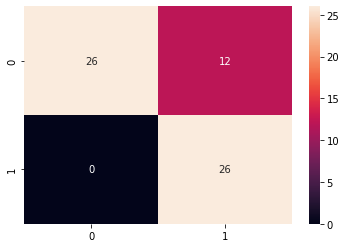

In [62]:
cf = tf.math.confusion_matrix(y_val_4, y_pred_4_binary, dtype=tf.dtypes.int32)
sns.heatmap(cf, annot=True)
plt.show();

In [63]:
print(classification_report(y_val_4, y_pred_4_binary))

              precision    recall  f1-score   support

           0       1.00      0.68      0.81        38
           1       0.68      1.00      0.81        26

    accuracy                           0.81        64
   macro avg       0.84      0.84      0.81        64
weighted avg       0.87      0.81      0.81        64

